# Kill The Fly
Hello surfer, if you were following our series [#7DaysOfComputerVisionProjects]() then this is the 6th project and this is going to be different and fun than the previous because in this project, we are going to kill the fly. Don't get confused, we will not kill the real fly. If you are here first then I hope you can follow some of previous projects too. 

1. [Live Background Changing]()
2. [Air Mouse]()
3. [Play Trex Game With Gesture]()
4. [Auto Dino: Play Trex Game Automatically]()
5. [Gesture Based Writing]()
6. [Kill The Fly]()
7. 

## What will we do?
In this project, we will write a code with which, some house flies will spawn in random location of our live frame. If we move our hand over that place then the flies should die and our score should be increased else our live should decrease. The flies should disappear randomly. 

## Preliminary Tasks
### Imports
We will be using `NumPy`, `Matplotlib`, `Mediapipe`, and `OpenCV`. 

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Common Functions
* We will define a `show` function which will take `image` and `fsize` then shows image on given sized `figure`.

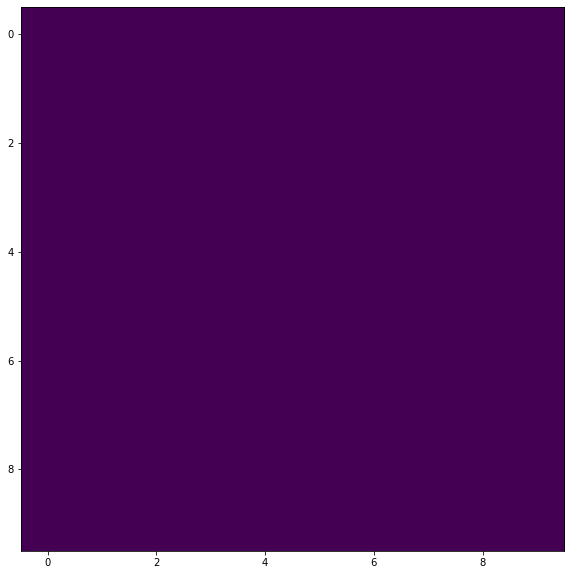

In [2]:
def show(img, fsize=(10, 10)):
    figure = plt.figure(figsize=fsize)
    plt.imshow(img)
    plt.show()
show(np.zeros((10, 10)))


## Prepare Flies Image
We will be using some fly images from google and I have already downloaded 3 of alive fly and 2 of dead flies. **Make sure all of those have black background.** If some flies doesn't have complete black background then we must do something like thresholding pixel values. 
* Read file names of alive fly and dead fly names.
* Loop through all names and read images.
* Make a mask of pixels and if sum of pixel values is below 20 then replace that pixel as black and save it back.

In [3]:
fly_names = ["fly/fly1.jpg", "fly/fly2.jpg", "fly/fly3.jpg"]
dead_fly_names = ["fly/deadfly1.jpg", "fly/deadfly2.jpg"]

all_fly_names = [fn for fnn in [fly_names, dead_fly_names] for fn in fnn]

for fname in all_fly_names:
    img = cv2.imread(fname)
    mask=np.sum(img, axis=-1)<20
    img[mask] = [0, 0, 0]
    cv2.imwrite(fname, img)
# dead_flies[0]

Make list of images and show some.

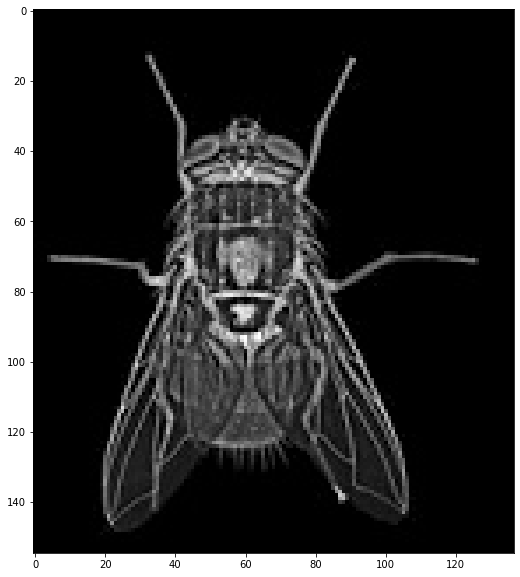

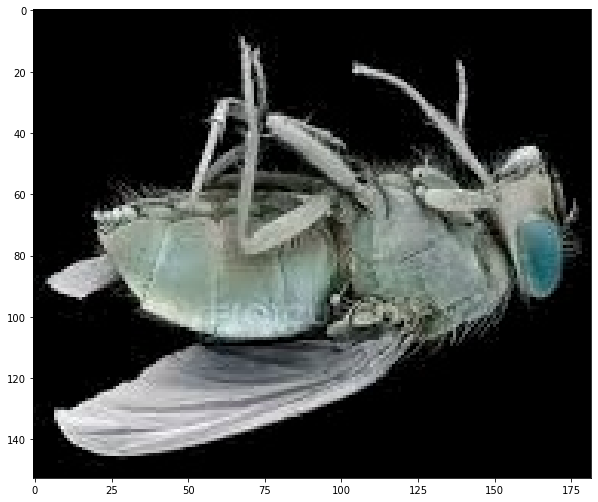

In [4]:
flies = [cv2.imread(fly) for fly in fly_names]
dead_flies = [cv2.imread(fly) for fly in dead_fly_names]

# see 1 fly and dead fly
show(flies[0])
show(dead_flies[0])

## Creating Classes for Fly

We will represent each fly as a single object and by doing so, we can treat them according to their atributes and edit their property. The concept of using this class is somewhat similar to the simple game coding in Unity3D and C#. 

### Make a Base class
We will add flies, both dead and alive in list. Since this will be repeatitive task, we will inherit this class from another `Fly` class.
```python
class AllFlies:
    fly_names = ["fly/fly1.jpg", "fly/fly2.jpg", "fly/fly3.jpg"]
    dead_fly_names = ["fly/deadfly1.jpg", "fly/deadfly2.jpg"]

    flies = [cv2.imread(fly) for fly in fly_names]
    dead_flies = [cv2.imread(fly) for fly in dead_fly_names]
```

### Make a Fly Class
* Define a class and inherit it from `AllFlies` class. Initialize it by giving `disappear_in=40, interactive=True, life=0, fly_size=(80, 80), hit=False, fsize=(520, 720)`. For simplicity, please look at docstring and comments.
* Once all value has been assigned, we will make a fly by calling that function.

```python
class Fly(AllFlies):
    def __init__(self, disappear_in=40, interactive=True, 
                 life=0, fly_size=(80, 80), hit=False, fsize=(520, 720)):
        
        """
        disappear_in: Disappear in that frames from its origin.
        interactive: True while it is alive.
        life: if life reaches disappear_in then fly will disappear.
        hit: if our hand hit the fly.
        fly_size: size of fly.
        fsize: fraeme size.
        """
        
        self.fly_size = fly_size
        self.disappear_in = disappear_in
        self.interactive = interactive
        self.life=life
        self.hit = hit
        self.fsize = fsize
        # After everything is assigned, make a fly with those properties.
        self.make_fly()
        
        
    def make_fly(self):
        # randmoly choose current fly image and resize it to fly_size
        curr_fly = self.flies[np.random.randint(0, len(self.flies))]
        curr_fly = cv2.resize(curr_fly, self.fly_size)
        
        # randomly choose dead fly and if current fly gets hit, then we will replace image 
        dfly = self.dead_flies[np.random.randint(0, len(self.dead_flies))]
        dfly = cv2.resize(dfly, self.fly_size)
        
        # take shape and take its half
        cshape = curr_fly.shape
        cshape = (int(cshape[0]/2), int(cshape[1]/2))
        h,w=self.fsize
        
        # should be those position where current fly can be completely seen so we will limit its position within that range
        random_x = np.random.randint(cshape[0], h-cshape[0])
        random_y = np.random.randint(cshape[1], w-cshape[1])

        # get rectangle where we will replace fly. 
        x1, x2 = random_x-cshape[0], random_x+cshape[0]
        y1, y2 = random_y-cshape[1], random_y+cshape[1]

        # save rectangle coordinates in position
        self.position = (x1, x2, y1, y2)
        
        # save current fly as image and dead image as dead fly
        self.image = curr_fly
        self.dead_image = dfly

        
    def update(self):
        # if fly was hit, then we have to replace image by dead image and make interactive false 
        # and decrease the disappear in value so that our screen wont be flooded 
        if self.hit:
            self.image = self.dead_image
            self.interactive = False
            self.disappear_in -= 20
            

f = Fly()
show(f.image)
show(f.dead_image)
```

## Main Code
* Define a camera source and frame size.
```python
cam = cv2.VideoCapture(0)
fsize = (600, 820)
```
* Define drawing and hand modules.
```python
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
```
* Define variables like level, previous level, show every and check count.
```python
level=1
plevel = 0
show_every = 30
check_cnt = 0
```
* Define fly shape*
```python
fly_shape = (80, 80)
```
* Define a list to store all flies.
```python
all_flies = []
```
* Define variables like minmimum disappear in, score, previous score and lives. Initially we will have 20 lives and once an alive fly disappears, our lives decreases by 1.  
```python
min_disappear_in = 40
score = 0
pscore = -1
lives = 20
```
* Define a fly window, wher we will show fly in testing phase.
```python
fly_window = np.zeros((fsize[0], fsize[1], 3)).astype(np.uint8)
```
* Take hands detection model.
```python
with mp_hands.Hands(static_image_mode=True,
                   max_num_hands = 1,
                   min_detection_confidence=0.2) as hands:
```
* If camera is open then try to read the frame and if it is not successful then skip. We will also define a key wait.
```python
    while cam.isOpened():
        ret, frame = cam.read()
        key = cv2.waitKey(1)&0xFF       
        if not ret:
            continue
```
* Flipe the frame and resize it into the frame size we defined earlier.
```python
        frame = cv2.flip(frame, 1)
        frame = cv2.resize(frame, fsize[::-1])
```
* Convert frame to RGB and pass it to process to get result.
```python
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)
```
* Take height and width from frame and make one dummy image of 100 rows and columns upto width of frame. This dummy image will be used to show details like score, lives.
```python
        h, w = frame.shape[:-1]
        d = np.zeros((100, w, 3)).astype(np.uint8)
```
* Initialize variables like xmin, xmax, ymin, ymax of hand coordinates. Initially, assume that no hand has been detected so these values should be impossible values.
```python
        xmin = h
        xmax = -1
        ymin = w
        ymax = -1
```
* If hand has been detected, then we will get all landmark's x and y coordinates and then convert it into our frame world. Then we will find xmin, xmax, ymin and ymax of landmarks. These values will give us coordinates with which we could draw a rectangle surrounding the hand. We will show the landmarks too.

```python
        if res.multi_hand_landmarks:
            for hand_landmarks in res.multi_hand_landmarks:
                x = np.array([landmark.x * w for landmark in hand_landmarks.landmark]).astype("int32")
                y = np.array([landmark.y * h for landmark in hand_landmarks.landmark]).astype("int32")
                
                xmin = min(x)
                xmax = max(x)
                ymin = min(y)
                ymax = max(y)
                
                cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)
                
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
```

* If our lives is not 0, then we will play the game else we will show game over message.
```python
        if lives>0:
```
* We will loop through all Fly objects that we append in the list.
```python
            for fly in all_flies:
```
* Extract the fly position, get the mask of fly. Take life of fly as v, and disappear in.

```python
                x1, x2, y1, y2 = fly.position

                mask = np.sum(fly.image,axis=-1)!=0

                v = fly.life
                disappear_in = fly.disappear_in
```

* If the life is 0, then increase it by one and show the fly image on fly window by applying a mask.
```python
                if v==0:
                    fly.life+=1
                    fly_window[x1:x2, y1:y2][mask] = fly.image[mask]
 ```
 * If life is smaller than disappear in then, we will increase life.
 ```python
                elif v<disappear_in:
                    fly.life+=1
```
* If life is equal or greater than disappear in then we will remove the fly. But if the fly was not hit, then we will show red in details image. Then we will decrease lives. Since the fly's life has expired and we did not kill it, our live will decrease now and we will fill its position by black color. Then remove the fly object from list.
```python
                if v>=disappear_in:
                    if not fly.hit:
                        d+=np.array([0, 0, 255]).astype(np.uint8)
                        lives -= 1
                    fly_window[x1:x2, y1:y2] = [0, 0, 0]
                    all_flies.remove(fly)
```
* Now check if the hand rectangle contains the any portion of fly. And if it does and if the fly is still alive, then make hit true and increase the score bu 5 times of level. Then update the state of fly. The update method of fly will change the image to dead image and then we will apply mask on fly window to show dead fly. Else, we will show fly image in frame by applying fly mask.

```python
                elif ymin<x1 and ymax>x2 and xmin<y1 and xmax>y2 and fly.interactive:
                    fly.hit = True

                    score+=level*5

                    fly.update()
                    #fly_window[x1:x2, y1:y2] = [0, 0, 0]
                    fly_window[x1:x2, y1:y2][mask] = fly.image[mask] 
                    frame[x1:x2, y1:y2][mask] = fly.image[mask]
                else:                
                    frame[x1:x2, y1:y2][mask] = fly.image[mask]
```

* If show every is smaller or equal to check count, then we will create a random life for our new fly to be spawned. Then make an object of Fly and append it in all flies. At last, make check count back to 0.

```python
            if show_every<=check_cnt:
                random_life = min_disappear_in+np.random.randint(0, min_disappear_in)
                all_flies.append(Fly(disappear_in=random_life, fsize=fsize))


                check_cnt=0
```

* To change the score, we check if score is not 0 and if score is divisible by 10 and previous score and current score are not equal then we will increase level by one. While increaseing level, we will change few variables to add difficulty. show every will be decreased by 2, minimum disappear value will be also decreased by 2.

```python
            if score!=0 and score%10==0 and pscore!=score:
                pscore = score
                plevel = level
                level+=1

                show_every = np.clip(show_every-2, 10, 1000)
                min_disappear_in = np.clip(min_disappear_in-2, 10, 1000)
```

* We will have to show the details of current state of game. That is, score, level, alive flies, our live ets.  So count the alive flies and add it in text. Then put the text in our details image.
```python
            num_flies = sum([1 for v in all_flies if v.interactive])
            text = f"Level: {level} | Score: {score} | Lives: {lives} | Flies: {num_flies}"
            cv2.putText(d, text, (10, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (200, 100, 200), 2)
```
* If our lives is all exhausted, we will show Game Over text and if space key is hit, then we will restart the game.

```python
        else:
            text = f"GAME OVER!!! Score: {score} HIT SPACE TO RESTART!!"
            
            if key == 32:
                fly_window = np.zeros((fsize[0], fsize[1], 3)).astype(np.uint8)
                lives = 20
                all_flies = []
                score = 0
                level = 1
                
            cv2.putText(d, text, (10, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (200, 100, 200), 1)
```
* Finally, show the details and frame in one top of another and also show fly windows. Increase check count. If escape key was hit, then quit our game.
```python
        cv2.imshow("Window", np.vstack([d, frame]).astype(np.uint8))
        cv2.imshow("Fly", fly_window)
        check_cnt+=1
        if key == 27:
            break
cam.release()
#out.release()
cv2.destroyAllWindows()
```

## All Codes

In [ ]:
class AllFlies:
    fly_names = ["fly/fly1.jpg", "fly/fly2.jpg", "fly/fly3.jpg"]
    dead_fly_names = ["fly/deadfly1.jpg", "fly/deadfly2.jpg"]

    flies = [cv2.imread(fly) for fly in fly_names]
    dead_flies = [cv2.imread(fly) for fly in dead_fly_names]

class Fly(AllFlies):
    def __init__(self, disappear_in=40, interactive=True, 
                 life=0, fly_size=(80, 80), hit=False, fsize=(520, 720)):
        
        """
        disappear_in: Disappear in that frames from its origin.
        interactive: True while it is alive.
        life: if life reaches disappear_in then fly will disappear.
        hit: if our hand hit the fly.
        fly_size: size of fly.
        fsize: fraeme size.
        """
        
        self.fly_size = fly_size
        self.disappear_in = disappear_in
        self.interactive = interactive
        self.life=life
        self.hit = hit
        self.fsize = fsize
        # After everything is assigned, make a fly with those properties.
        self.make_fly()
        
        
    def make_fly(self):
        # randmoly choose current fly image and resize it to fly_size
        curr_fly = self.flies[np.random.randint(0, len(self.flies))]
        curr_fly = cv2.resize(curr_fly, self.fly_size)
        
        # randomly choose dead fly and if current fly gets hit, then we will replace image 
        dfly = self.dead_flies[np.random.randint(0, len(self.dead_flies))]
        dfly = cv2.resize(dfly, self.fly_size)
        
        # take shape and take its half
        cshape = curr_fly.shape
        cshape = (int(cshape[0]/2), int(cshape[1]/2))
        h,w=self.fsize
        
        # should be those position where current fly can be completely seen so we will limit its position within that range
        random_x = np.random.randint(cshape[0], h-cshape[0])
        random_y = np.random.randint(cshape[1], w-cshape[1])

        # get rectangle where we will replace fly. 
        x1, x2 = random_x-cshape[0], random_x+cshape[0]
        y1, y2 = random_y-cshape[1], random_y+cshape[1]

        # save rectangle coordinates in position
        self.position = (x1, x2, y1, y2)
        
        # save current fly as image and dead image as dead fly
        self.image = curr_fly
        self.dead_image = dfly

        
    def update(self):
        # if fly was hit, then we have to replace image by dead image and make interactive false 
        # and decrease the disappear in value so that our screen wont be flooded 
        if self.hit:
            self.image = self.dead_image
            self.interactive = False
            self.disappear_in -= 20
            

f = Fly()
show(f.image)
show(f.dead_image)

In [6]:
cam = cv2.VideoCapture(0)

fsize = (600, 820)
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands


level=1

show_every = 30
check_cnt = 0

fly_shape = (80, 80)


all_flies = []

min_disappear_in = 40
score = 0
pscore = -1
lives = 1

fly_window = np.zeros((fsize[0], fsize[1], 3)).astype(np.uint8)

with mp_hands.Hands(static_image_mode=True,
                   max_num_hands = 1,
                   min_detection_confidence=0.2) as hands:
    
    while cam.isOpened():
        ret, frame = cam.read()
        key = cv2.waitKey(1)&0xFF
        
        
        if not ret:
            continue
        frame = cv2.flip(frame, 1)
        frame = cv2.resize(frame, fsize[::-1])
        
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)
        h, w = frame.shape[:-1]
        d = np.zeros((100, w, 3)).astype(np.uint8)
        
        xmin = h
        xmax = -1
        ymin = w
        ymax = -1
        
        if res.multi_hand_landmarks:
            for hand_landmarks in res.multi_hand_landmarks:
                x = np.array([landmark.x * w for landmark in hand_landmarks.landmark]).astype("int32")
                y = np.array([landmark.y * h for landmark in hand_landmarks.landmark]).astype("int32")
                
                xmin = min(x)
                xmax = max(x)
                ymin = min(y)
                ymax = max(y)
                
                cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)
                
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        if lives>0:

            for fly in all_flies:
                x1, x2, y1, y2 = fly.position

                mask = np.sum(fly.image,axis=-1)!=0

                v = fly.life
                disappear_in = fly.disappear_in

                if v==0:
                    fly.life+=1
                    fly_window[x1:x2, y1:y2][mask] = fly.image[mask]
                if v<disappear_in:
                    fly.life+=1

                if v>=disappear_in:
                    if not fly.hit:
                        d+=np.array([0, 0, 255]).astype(np.uint8)
                        lives -= 1
                    fly_window[x1:x2, y1:y2] = [0, 0, 0]
                    all_flies.remove(fly)

                elif ymin<x1 and ymax>x2 and xmin<y1 and xmax>y2 and fly.interactive:
                    fly.hit = True

                    score+=level*5

                    fly.update()
                    #fly_window[x1:x2, y1:y2] = [0, 0, 0]
                    fly_window[x1:x2, y1:y2][mask] = fly.image[mask]
                    frame[x1:x2, y1:y2][mask] = fly.image[mask]
                else:                
                    frame[x1:x2, y1:y2][mask] = fly.image[mask]

            if show_every<=check_cnt:
                random_life = min_disappear_in+np.random.randint(0, min_disappear_in)
                all_flies.append(Fly(disappear_in=random_life, fsize=fsize))


                check_cnt=0

            if score!=0 and score%10==0 and pscore!=score:
                pscore = score
                plevel = level
                level+=1

                show_every = np.clip(show_every-2, 10, 1000)
                min_disappear_in = np.clip(min_disappear_in-2, 10, 1000)
            num_flies = sum([1 for v in all_flies if v.interactive])
            text = f"Level: {level} | Score: {score} | Lives: {lives} | Flies: {num_flies}"
            cv2.putText(d, text, (10, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (200, 100, 200), 2)
        else:
            text = f"GAME OVER!!! Score: {score} HIT SPACE TO RESTART!!"
            
            if key == 32:
                fly_window = np.zeros((fsize[0], fsize[1], 3)).astype(np.uint8)
                lives = 20
                all_flies = []
                score = 0
                level = 1
                
            cv2.putText(d, text, (10, 70), cv2.FONT_HERSHEY_COMPLEX, 1, (200, 100, 200), 1)
                
              
        
        cv2.imshow("Window", np.vstack([d, frame]).astype(np.uint8))
        cv2.imshow("Fly", fly_window)
        check_cnt+=1
        if key == 27:
            break
cam.release()
#out.release()
cv2.destroyAllWindows()

## Finally
Thank you for reaching to the endo of this blog and if you found any problems then please let us know. The link to the YouTube video and GitHub repository is below.
* [YouTube]()
* [GitHub]()